In [168]:
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.types import FloatType
from pyspark.sql.functions import col, asc, desc, when, isnull, create_map
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.stat import Correlation
from pyspark_dist_explore import hist
from functools import reduce

import matplotlib.pyplot as plt
import pyspark
import glob

In [ ]:
spark = SparkSession.builder.appName("spark-sql").config("spark.driver.memory", "32g").getOrCreate()

In [57]:
# load data
parquet_files = glob.glob('./data/*.parquet')

dfs = []
for f in parquet_files:
    dfs.append(spark.read.parquet(f))
    
df_raw = reduce(DataFrame.union, dfs)

df_raw.printSchema()

In [6]:
# subset columns
cols = [
    "FlightDate",
    "Airline",
    "Tail_Number",
    "Flight_Number_Marketing_Airline",
    "Origin",
    "Dest",
    "Cancelled",
    "Diverted",
    "DepDelayMinutes",
    "CRSDepTime",
    "DepTime",
    "CRSArrTime",
    "ArrTime",
    "ArrDelayMinutes",
    "AirTime",
    "Distance",
    "ArrivalDelayGroups"
]

df = df_raw.select(*cols)

In [11]:
# create variable on_time
"""
on_time: (bool) if depdelaymin == 0 and arrdelaymin == 0 then true
"""
df = df.withColumn(
    "on_time",
    when(((col("ArrDelayMinutes") == 0.0) | (col("DepDelayMinutes") == 0.0)) & ~col("Cancelled"), True)
    .otherwise(False)
)

In [12]:
# create variable delay_group
"""
delay_group: (string) delaymin == 0, on time
                      delaymin > 0, delaymin <= 15, small delay
                      delaymin > 15, delaymin <= 45, medium delay
                      delaymin > 45, large  delay
                      otherwise cancelled
"""
df = df.withColumn(
    "delay_group",
    when(col("on_time"), "On Time")
    .when(((col("DepDelayMinutes") > 0) & (col("DepDelayMinutes") <= 15)) | ((col("ArrDelayMinutes") > 0) & (col("ArrDelayMinutes") <= 15)), "Small Delay")
    .when(((col("DepDelayMinutes") > 15) & (col("DepDelayMinutes") <= 45)) | ((col("ArrDelayMinutes") > 15) & (col("ArrDelayMinutes") <= 45)), "Medium Delay")
    .when((col("DepDelayMinutes") > 45) | (col("ArrDelayMinutes") > 45), "Large Delay")
    .otherwise("Cancelled")
)


In [ ]:
# cast variable types long -> double
cols_long = [
    "Flight_Number_Marketing_Airline",        
    "CRSDepTime",
    "CRSArrTime"
]

for c in cols_long:
    df = df.withColumn(c, col(c).cast("double"))

df.printSchema()

In [ ]:
# top 10 performers
df_airline = df.groupBy("Airline").count().withColumnRenamed("count", "total")
df_on_time = df.filter(col("delay_group") == "On Time").groupBy("Airline").count().withColumnRenamed("count", "on_time_count")

df_airline = df_airline \
    .join(df_on_time, "Airline") \
    .withColumn("pct", (col("on_time_count") / col("total")))

df_airline.orderBy(col("pct").desc()).show(10, truncate = False)

In [ ]:
# bottom 10 performers
df_airline.orderBy(col("pct").asc()).show(10, truncate = False)

In [ ]:
# unique plane ID
df_plane = df.filter(~isnull(col("Tail_Number"))).groupBy("Tail_Number").count()
df_plane.orderBy(col("count").desc()).show(10)
df_plane.distinct().count()

In [119]:
# linear regression

variables_d = [
    "DepDelayMinutes",
    "CRSDepTime",
    "DepTime",
    "Distance",
    "Cancelled",
    "Diverted",
    "on_time"
]

variables_a = [
    "ArrDelayMinutes",
    "CRSArrTime",
    "ArrTime",
    "Distance",
    "Cancelled",
    "Diverted",
    "on_time"
]

predictors_d = [
    "DepDelayMinutes",
    "CRSDepTime",
    "DepTime",
    "Distance",
    "Cancelled",
    "Diverted",
    "on_time"
]

predictors_a = [
    "ArrDelayMinutes",
    "CRSArrTime",
    "ArrTime",
    "Distance",
    "Cancelled",
    "Diverted",
    "on_time"
]

df_lr_d = df.select(*variables_d).dropna()
df_lr_a = df.select(*variables_a).dropna()

In [104]:
# departure delay
# put predoctors into a vector column
assembler = VectorAssembler(inputCols = predictors_d, outputCol = "features")
assembled_df_d = assembler.transform(df_lr_d)

# assembled_df_d.show()

# subset features and response
df_analysis_d = assembled_df_d.select("features", "DepDelayMinutes")

# split data intro train and test
train_data_d, test_data_d = assembled_df_d.randomSplit([0.7, 0.3])

# build model
lr_d = LinearRegression(featuresCol = "features", labelCol = "DepDelayMinutes", predictionCol = "predDepDelay")

# fit data to model
mod_d = lr_d.fit(train_data_d)

In [ ]:
# regression coefficients departure
d = [mod_d.intercept]
coeffs_d = mod_d.coefficients.toArray().tolist()

for elem in coeffs_d:
    d.append(elem)

vars_d = variables_d
vars_d[0] = "intercept"
vars_d

data_d = list(map(lambda x, y: (x, y), vars_d, d))
cols_d = ["variable", "coeffcient"]

coef_df_d = spark.createDataFrame(data_d, cols_d)
coef_df_d.show(truncate = False)

In [ ]:
# generate predictions departure
pred_results_d = mod_d.transform(test_data_d)
pred_results_d.select("DepDelayMinutes", "PredDepDelay").show(truncate = False)

In [181]:
# arrival delay
# put predoctors into a vector column
assembler = VectorAssembler(inputCols = predictors_a, outputCol = "features")
assembled_df_a = assembler.transform(df_lr_a)

# assembled_df_a.show()

# subset features and response
df_analysis_a = assembled_df_a.select("features", "ArrDelayMinutes")

# split data intro train and test
train_data_a, test_data_a = assembled_df_a.randomSplit([0.7, 0.3])

# build model
lr_a = LinearRegression(featuresCol = "features", labelCol = "ArrDelayMinutes", predictionCol = "predArrDelay")

# fit data to model
mod_a = lr_a.fit(train_data_a)

In [ ]:
# regression coefficients arrival
a = [mod_a.intercept]
coeffs_a = mod_a.coefficients.toArray().tolist()

for elem in coeffs_a:
    a.append(elem)

data_a = list(map(lambda x, y: (x, y), vars_d, a))

coef_df_a = spark.createDataFrame(data_a, cols_d)
coef_df_a.show(truncate = False)

In [ ]:
#print predicted results arrival
pred_results_a = mod_a.transform(test_data_a)
pred_results_a.select("ArrDelayMinutes", "predArrDelay").show(truncate = False)

(array([2.8269076e+07, 1.2285000e+05, 1.7885000e+04, 1.2041000e+04,
        6.1200000e+03, 1.8810000e+03, 5.9000000e+02, 1.3500000e+02,
        5.7000000e+01, 2.1000000e+01, 2.0000000e+01, 8.0000000e+00,
        1.0000000e+01, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        1.0000000e+00, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 1.0000000e+00]),
 array([   0.        ,  240.76666667,  481.53333333,  722.3       ,
         963.06666667, 1203.83333333, 1444.6       , 1685.36666667,
        1926.13333333, 2166.9       , 2407.66666667, 2648.43333333,
        2889.2       , 3129.96666667, 3370.73333333, 3611.5       ,
        3852.26666667, 4093.03333333, 4333.8       , 4574.56666667,
        4815.33333333, 5056.1       , 5296.86666667, 5537.63333333,
        5778.4       , 6019.16666667, 6259.93333333, 6500.7       ,
        

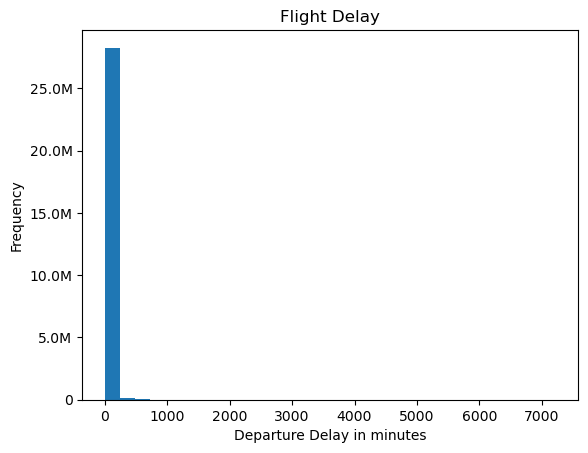

In [186]:
# plot histogram
fig, ax = plt.subplots()

ax.set_title("Flight Delay")
ax.set_xlabel('Departure Delay in minutes')
ax.set_ylabel('Frequency')

hist(ax, df.select('DepDelayMinutes'), bins = 30)